In [62]:
import pandas as pd
import numpy as np

import gensim
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

In [9]:
lgb_table = pd.read_csv("../data/lgb_table_ids.csv")
lgb_pages = pd.read_csv("../data/lgb_pages_v2.csv")

In [10]:
lgb_pages_nodups = lgb_pages.drop_duplicates()
lgb_merged = pd.merge(lgb_table, lgb_pages_nodups, how='inner', on='pageid')
lgb_merged.loc[lgb_merged.Notes == 'G.', 'Notes'] = 'G'

In [11]:
lgb_merged.columns

Index(['Name', 'Title', 'Lifetime', 'Nationality', 'Notable as', 'Notes',
       'pageid', 'title', 'url', 'summary', 'content'],
      dtype='object')

In [18]:
# relabel both Kray twins as B, not B & G
# Ronnie Kray describes himself as both homosexual and bisexual 
# according to his wiki entry
lgb_merged.loc[lgb_merged.title == 'Kray twins', 'Notes'] = 'B'

In [30]:
lgb_merged_nodups = lgb_merged.loc[:, ['Notes', 'title', 'pageid', 'url', 'summary', 'content']].drop_duplicates()

In [70]:
lgb_merged_nodups.reset_index(drop=True, inplace=True)

In [278]:
# leave off 'summary' because it's NaN for one entry (id 944193, Ian Campbell Dunn)
lgb_merged_nodups_v2 = (lgb_merged.groupby(['Notes', 'title', 'pageid', 'url', 'content'], 
                                           as_index=False, sort=False)
    .agg({'Nationality': 'first', 'Notable as': 'first'})
    .reset_index(drop=True))

In [2]:
d2v_model = Doc2Vec.load('../data/d2v_lgb_pages_v2.doc2vec')

In [44]:
doc_keys = pd.DataFrame({'title': list(d2v_model.docvecs.doctags.keys())})

In [52]:
# make sure identities are in order with right indices
identity_categories = doc_keys.merge(lgb_merged_nodups.loc[:, ['Notes', 'title']], on='title')

In [71]:
X = d2v_model.docvecs[d2v_model.docvecs.doctags]
y = identity_categories['Notes']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    train_size=0.75, test_size=0.25)

In [73]:
svm_clf = LinearSVC(loss='hinge')
svm_clf.fit(X_train, y_train)
y_svm = svm_clf.predict(X_test)

In [74]:
print(classification_report(y_test, y_svm))

             precision    recall  f1-score   support

          B       0.57      0.28      0.37        86
          G       0.90      0.97      0.93       474
          L       0.82      0.86      0.84       161

avg / total       0.84      0.86      0.85       721



In [61]:
accuracy_score(y_test, y_svm)

0.86269070735090148

Matches tf-idf in accuracy, but does better (though not great) with bi folks

In [76]:
print(confusion_matrix(y_test, y_svm))

[[ 24  38  24]
 [  7 460   7]
 [ 11  12 138]]


## t-SNE with identity labels

In [78]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

%matplotlib inline

In [79]:
tsne = TSNE(n_components=2, random_state=0)

In [80]:
X_tsne = tsne.fit_transform(X)

In [95]:
y_cat = pd.Categorical(y)

In [142]:
cmap = plt.cm.get_cmap('Dark2')

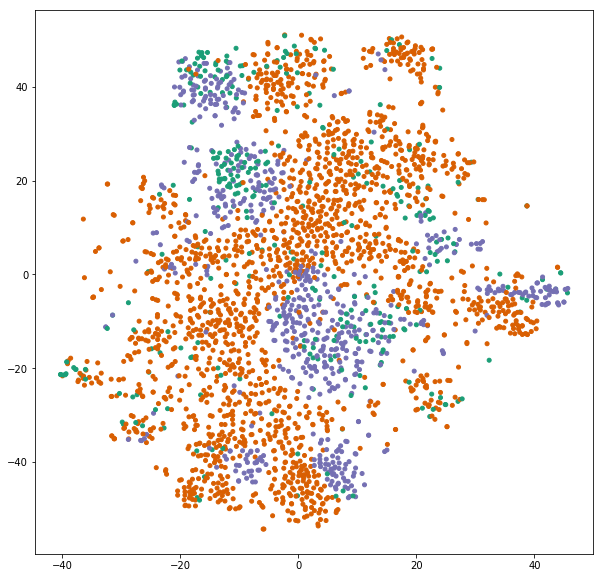

In [143]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=16, c=cmap(y_cat.codes))
plt.show()

In [167]:
df1 = pd.DataFrame(X_tsne, columns=['x', 'y'])
df2 = pd.DataFrame({'label': y_cat})

In [173]:
df3 = pd.concat([df1, df2], axis=1)

In [261]:
df4 = pd.concat([df1, identity_categories], axis=1)
df4.rename(columns={'Notes': 'label'}, inplace=True)

## other traits

In [281]:
df5 = pd.concat([df1, lgb_merged_nodups_v2], axis=1)
df5.rename(columns={'Notes': 'label'}, inplace=True)

In [288]:
df5['American'] = (df5['Nationality'] == 'American')

In [294]:
df5['notable'] = df5['Notable as'].str.lower()

In [296]:
df5['politician'] = df5['notable'].str.contains('politician')

In [344]:
df5['musician'] = df5['notable'].str.contains('musician|singer|composer')

In [313]:
df5['actor'] = df5['notable'].str.contains('actor|actress|film|television')

In [315]:
df5['writer'] = df5['notable'].str.contains('writer|author|poet')

In [181]:
# df3.groupby('label').plot.scatter(x='x', y='y')

In [253]:
import seaborn as sns

In [361]:
help(g.ax.legend)

Help on method legend in module matplotlib.axes._axes:

legend(*args, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Places a legend on the axes.
    
    To make a legend for lines which already exist on the axes
    (via plot for instance), simply call this function with an iterable
    of strings, one for each legend item. For example::
    
        ax.plot([1, 2, 3])
        ax.legend(['A simple line'])
    
    However, in order to keep the "label" and the legend element
    instance together, it is preferable to specify the label either at
    artist creation, or by calling the
    :meth:`~matplotlib.artist.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        # Overwrite the label by calling the method.
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label starting with an underscore.

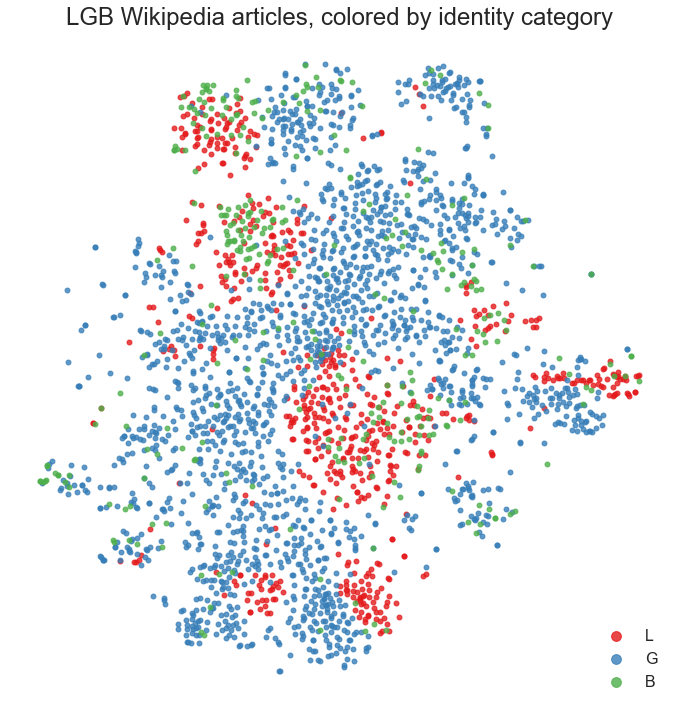

In [511]:
# palettes: husl, deep, Accent...
g = sns.lmplot(x='x', y='y', hue='label', data=df5, fit_reg=False, 
               palette='Set1', size=10, legend=False,
               scatter_kws={"alpha":0.8,"s":24})
g.set_axis_labels('', '')
g.despine(left=True, bottom=True)
g.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
g.ax.legend(loc='lower right', markerscale=2, fontsize=16)
g.ax.set_title('LGB Wikipedia articles, colored by identity category', size=24)
g.savefig('../output/tsne_lgb.png')
plt.show(g)

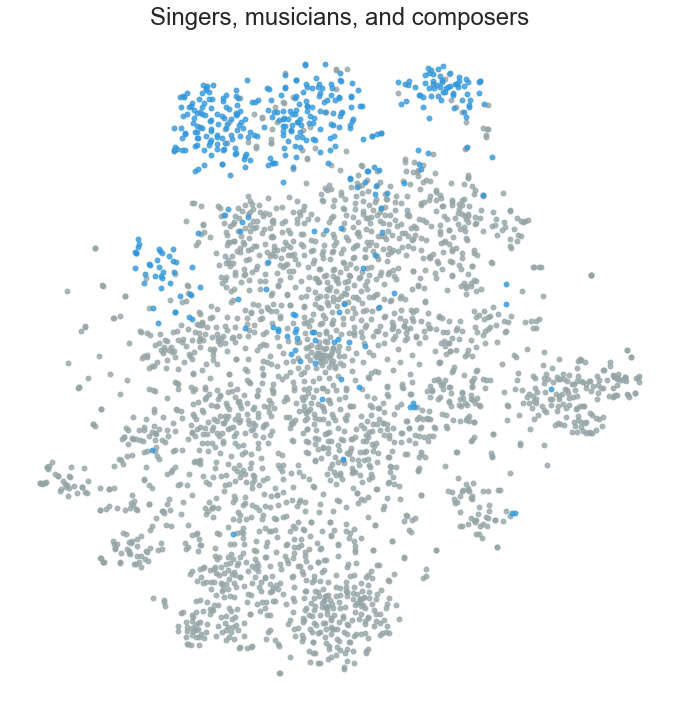

In [346]:
# palettes: husl, deep, Accent...
g = sns.lmplot(x='x', y='y', hue='musician', data=df5, fit_reg=False, 
               palette=sns.color_palette(["#95a5a6", "#3498db"]), 
               size=10, legend=False,
               scatter_kws={"alpha":0.8,"s":24})
g.set_axis_labels('', '')
g.despine(left=True, bottom=True)
g.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# g.ax.legend(loc='upper right', markerscale=2, fontsize='large')
g.ax.set_title('Singers, musicians, and composers', size=24)
g.savefig('../output/musicians.png')
plt.show(g)

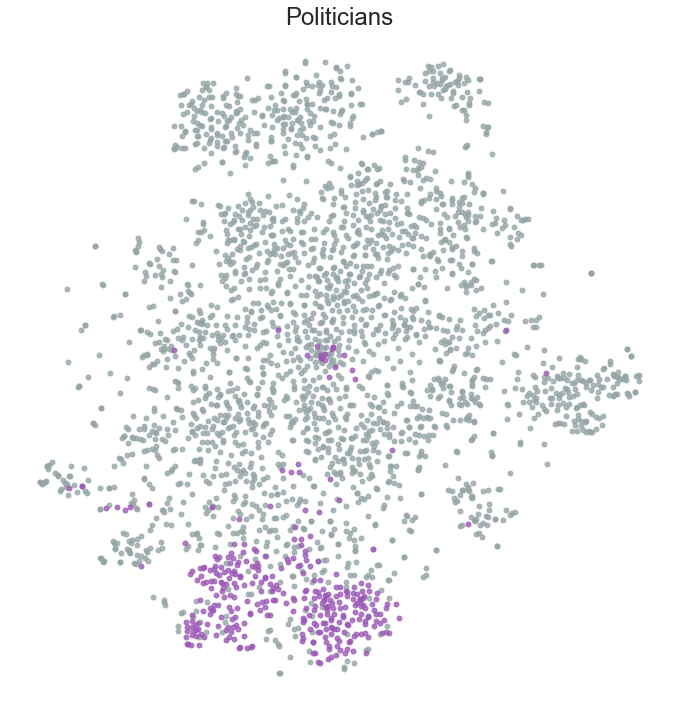

In [478]:
# palettes: husl, deep, Accent...
g = sns.lmplot(x='x', y='y', hue='politician', data=df5, fit_reg=False, 
               palette=sns.color_palette(["#95a5a6", "#9b59b6"]), 
               size=10, legend=False,
               scatter_kws={"alpha":0.8,"s":24})
g.set_axis_labels('', '')
g.despine(left=True, bottom=True)
g.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# g.ax.legend(loc='upper right', markerscale=2, fontsize='large')
g.ax.set_title('Politicians', size=24)
g.savefig('../output/politicians.png')
plt.show(g)

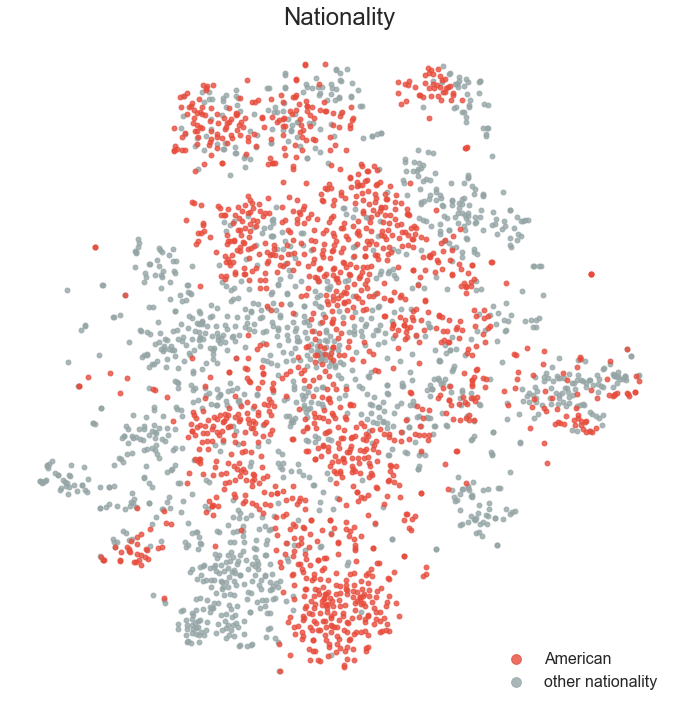

In [398]:
# palettes: husl, deep, Accent...
g = sns.lmplot(x='x', y='y', hue='American', data=df5, fit_reg=False, 
               palette=sns.color_palette(["#95a5a6", "#e74c3c"]), 
               size=10, legend=False,
               scatter_kws={"alpha":0.8,"s":24})
g.set_axis_labels('', '')
g.despine(left=True, bottom=True)
g.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# g.ax.legend(loc='lower right', markerscale=2, fontsize=16)
h, l = g.ax.get_legend_handles_labels()
g.ax.legend(reversed(h), reversed(l), loc='lower right', markerscale=2, fontsize=16)
g.ax.get_legend().texts[0].set_text('American')
g.ax.get_legend().texts[1].set_text('other nationality')
g.ax.set_title('Nationality', size=24)
g.savefig('../output/nationality.png')
plt.show(g)

In [144]:
tsne2 = TSNE(n_components=2, random_state=42)
X_tsne2 = tsne2.fit_transform(X)

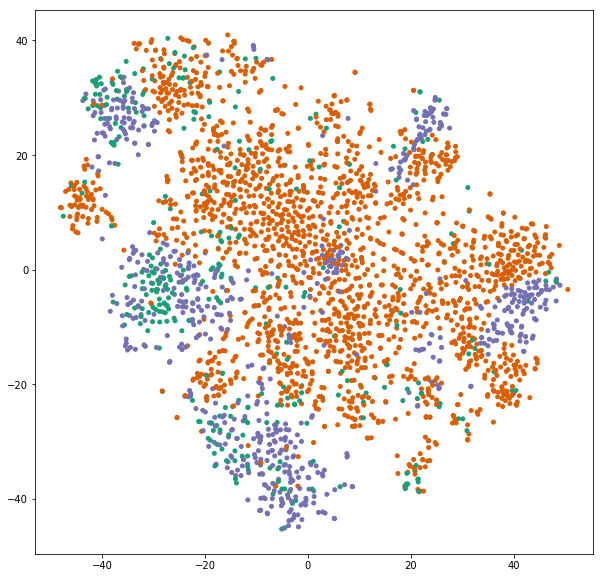

In [145]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(X_tsne2[:, 0], X_tsne2[:, 1], s=16, c=cmap(y_cat.codes))
plt.show()

## interactive plot: bokeh

In [468]:
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet, CDSView, IndexFilter, HoverTool, CategoricalColorMapper
from bokeh import palettes
from bokeh.resources import CDN
from bokeh.embed import file_html

In [477]:
# def interactive_tsne(bokeh_df):
#    '''makes an interactive scatter plot with text labels for each point'''
bokeh_df = df5.loc[:, ['x', 'y', 'title', 'label', 'Nationality', 'Notable as']]

# interactive controls to include to the plot
TOOLS="pan, wheel_zoom, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select, crosshair, tap"

p = figure(title="List of LGB people on Wikipedia", 
           tools=TOOLS, plot_width=700, plot_height=700, active_scroll="wheel_zoom")

hover = HoverTool(tooltips=[
    ("name", "@title"),
    ("label", "@label"),
    ("nationality", "@Nationality"),
    ("notable as", "@{Notable as}"),
])

p.add_tools(hover)

# define data source for the plot
source = ColumnDataSource(bokeh_df)

# color
color_mapper = CategoricalColorMapper(palette=palettes.Set1[3], factors=["L", "G", "B"])

# scatter plot
p.scatter('x', 'y', source=source, fill_alpha=0.6, size=6,
          # fill_color="#8724B5",
          fill_color={'field': 'label', 'transform': color_mapper},
          line_color=None, 
          legend='label')

html = file_html(p, CDN, 'List of LGB people on Wikipedia')

# show plot inline
output_notebook()
show(p)

Loading BokehJS ...

In [471]:
with open('../output/lgb_wikipedia.html', 'w') as f:
    f.write(html)

In [475]:
df5.groupby('label')['pageid'].count()

label
B     340
G    1883
L     659
Name: pageid, dtype: int64

In [485]:
help(g.ax.text)

Help on method text in module matplotlib.axes._axes:

text(x, y, s, fontdict=None, withdash=False, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Add text to the axes.
    
    Add text in string `s` to axis at location `x`, `y`, data
    coordinates.
    
    Parameters
    ----------
    x, y : scalars
        data coordinates
    
    s : string
        text
    
    fontdict : dictionary, optional, default: None
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by your rc parameters.
    
    withdash : boolean, optional, default: False
        Creates a `~matplotlib.text.TextWithDash` instance instead of a
        `~matplotlib.text.Text` instance.
    
    Other Parameters
    ----------------
    **kwargs : `~matplotlib.text.Text` properties.
        Other miscellaneous text parameters.
    
    Examples
    --------
    Individual keyword arguments can be used to override any given
    p

In [482]:
df5[df5.title == 'Tammy Baldwin'].x

189    9.689264
Name: x, dtype: float32

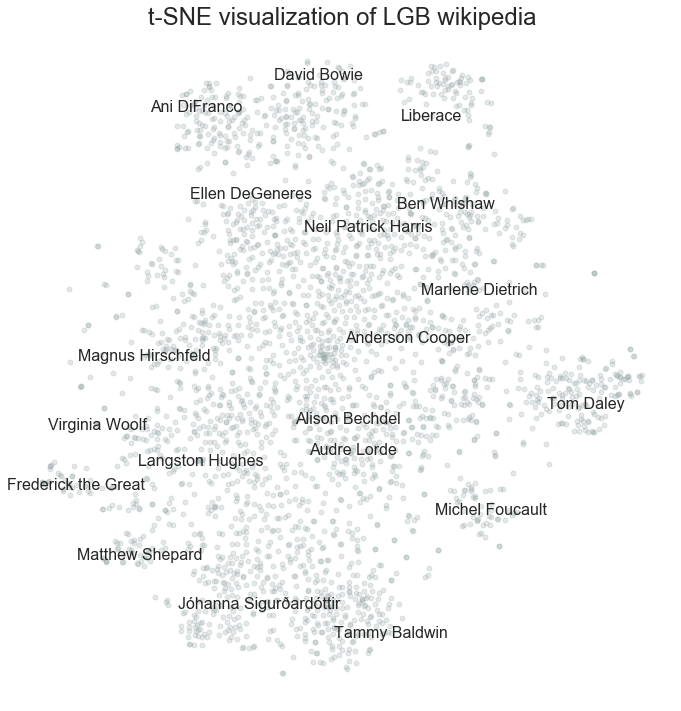

In [509]:
# palettes: husl, deep, Accent...
g = sns.lmplot(x='x', y='y', data=df5, fit_reg=False, 
               size=10, legend=False,
               scatter_kws={"alpha":0.25,"s":24,"color":"#95a5a6"})
g.set_axis_labels('', '')
g.despine(left=True, bottom=True)
g.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# g.ax.legend(loc='lower right', markerscale=2, fontsize=16)
g.ax.set_title('t-SNE visualization of LGB wikipedia', size=24)
# g.savefig('../output/tsne_lgb.png')
names = ['Michel Foucault', 'Tammy Baldwin', 'Matthew Shepard', 
         'Ellen DeGeneres', 'Virginia Woolf', 'Tom Daley', 
         'Langston Hughes', 'Audre Lorde', 'David Bowie', 'Marlene Dietrich', 
         'Alison Bechdel', 'Magnus Hirschfeld', 'Ben Whishaw', 
         'Neil Patrick Harris', 'Anderson Cooper', 'Jóhanna Sigurðardóttir', 
         'Frederick the Great', 'Liberace', 'Ani DiFranco']
for name in names:
    g.ax.text(x=df5[df5.title == name].x, 
              y=df5[df5.title == name].y, 
              s=name, 
              horizontalalignment='center',
              verticalalignment='center',
              fontsize=16)
g.savefig('../output/tsne_names.png')
plt.show(g)